In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn import preprocessing 


## 資料觀察與前處理

In [2]:
df_train = pd.read_csv("./train.csv", encoding="utf-8")
print(df_train.shape)
df_train.head()

(2264, 6)


,Date,Open Price,Close Price,High Price,Low Price,Volume
0,02-Jan-2009,902.99,931.80,934.73,899.35,4048270080
1,05-Jan-2009,929.17,927.45,936.63,919.53,5413910016
2,06-Jan-2009,931.17,934.70,943.85,927.28,5392620032
3,07-Jan-2009,927.45,906.65,927.45,902.37,4704940032
4,08-Jan-2009,905.73,909.73,910.00,896.81,4991549952


In [3]:
df_test = pd.read_csv("./test.csv", encoding="utf-8")
print(df_test.shape)
df_test.head()

(252, 6)


,Date,Open Price,Close Price,High Price,Low Price,Volume
0,02-Jan-2018,2683.73,2695.81,2695.89,2682.36,1846463232
1,03-Jan-2018,2697.85,2713.06,2714.37,2697.77,2090595328
2,04-Jan-2018,2719.31,2723.99,2729.29,2719.07,2100767744
3,05-Jan-2018,2731.33,2743.15,2743.45,2727.92,1918869120
4,08-Jan-2018,2742.67,2747.71,2748.51,2737.60,1894823936


- 畫出 trainset 跟 testset 上 Close Price 的走勢
- 綠線右邊是 testset

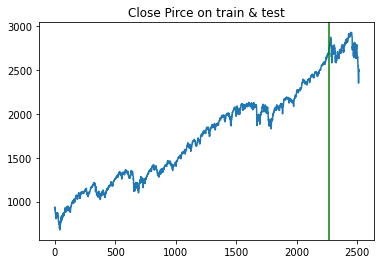

In [4]:
plt.plot(range(len(df_train)+len(df_test)), np.concatenate((df_train['Close Price'].values, df_test['Close Price'].values), axis=None))
plt.axvline(x=len(df_train), c='green')
plt.title('Close Pirce on train & test')
plt.show()

### 觀察成交量與 close price 的關聯性
- 發現 volumn 與 price 的差距實在太大，所以必須做 normalize

Text(0.5, 1.0, 'Volumn & ClosePrice Before Scale')

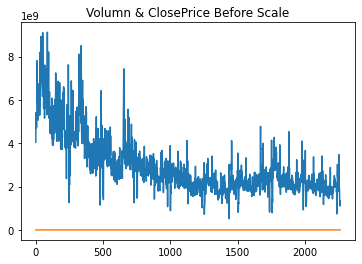

In [5]:
plt.plot(range(len(df_train)), df_train.Volume)
plt.plot(range(len(df_train)), df_train['Close Price'])
plt.title('Volumn & ClosePrice Before Scale')

- Scale 過後的 Volumn & Close Price

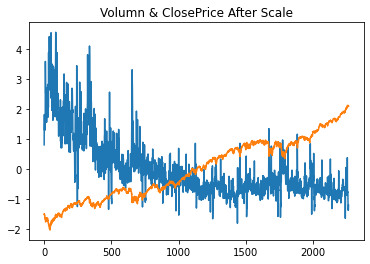

In [6]:
plt.plot(range(len(df_train)), preprocessing.scale(df_train.Volume))
plt.plot(range(len(df_train)), preprocessing.scale(df_train['Close Price']))
plt.title('Volumn & ClosePrice After Scale')
clear_output()
plt.show()

### 得到訓練資料
- 這邊打算用**每個今天**的資料去預測**每個明天**的 close price
- 使用了 `Open Price`, `Close Price`, `High Price`, `Low Price`, `Volume`
- 因為值的大小不一，所以我簡單的做了 scale，然後只取到倒數第二筆去當 train_X

In [7]:
train_X = preprocessing.scale(df_train[['Open Price','Close Price', 'High Price', 'Low Price', 'Volume']][:-1])

test_X = pd.DataFrame(df_train[['Open Price','Close Price', 'High Price', 'Low Price', 'Volume']][-1:])
test_X = test_X.append(pd.DataFrame(df_test[['Open Price','Close Price', 'High Price', 'Low Price', 'Volume']][:-1]), ignore_index = True)
test_X = preprocessing.scale(test_X)

clear_output()
print('train X')
print(train_X.shape)
print(train_X[:5])

print('\ntest X')
print(test_X.shape)
test_X[:5]

train X
(2263, 5)
[[-1.5525723  -1.49460743 -1.50568322 -1.5411813   0.81317476]
 [-1.4985713  -1.50358103 -1.50176025 -1.49958133  1.82382578]
 [-1.49444594 -1.48862502 -1.48685296 -1.48360512  1.80806999]
 [-1.50211912 -1.54648932 -1.52071439 -1.53495573  1.29914778]
 [-1.54692055 -1.54013559 -1.55674377 -1.54641737  1.51125538]]

test X
(252, 5)


array([[-0.60956457, -0.73810299, -0.77958363, -0.54464921, -1.79825248],
       [-0.66507711, -0.51389255, -0.73839392, -0.4614655 , -0.66999679],
       [-0.52045772, -0.33967497, -0.53648781, -0.3149671 , -0.13420764],
       [-0.30066083, -0.22928668, -0.37347704, -0.11247419, -0.11188255],
       [-0.17754999, -0.03577893, -0.21876977, -0.0283398 , -0.51108983]])

- 將 train_X 畫出來，發現除了成交量以外的東西差不多都疊在一起了

Text(0.5, 1.0, 'After Scale')

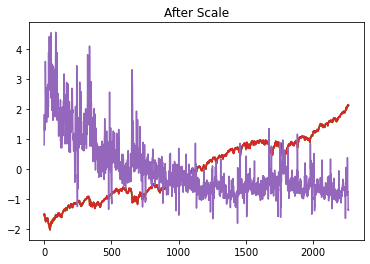

In [8]:
plt.plot(range(len(df_train)-1), train_X)
plt.title('After Scale')

- 拿到 ans_x 與 ans_y
- 定義一個 getdiff function, 用今天的close price去減昨天，用來取得每天的漲跌情況
- 將每天的 close price 做 diff 去得到漲跌答案
- 1 為漲, 0 為跌

In [9]:
def getdiff(data, flag=False):
    d = np.diff(data)
    if flag==False:
        tmp = []
    else:
        tmp = [1]
    for i in d:
        if(i>=0):
            tmp.append(1)
        else:
            tmp.append(0)
    tmp = np.array(tmp)
    return tmp

ans_x = getdiff(df_train['Close Price'])
print(ans_x.shape)

ans_y = getdiff(df_test['Close Price'], True)
print(ans_y.shape)

(2263,)
(252,)


- 查看答案的分布情形
- 可以發現在 train 跟 test 上都還算平衡， 不過 漲(1) 的情況稍微多一些

ans_x 0:  1024
ans_x 1:  1239


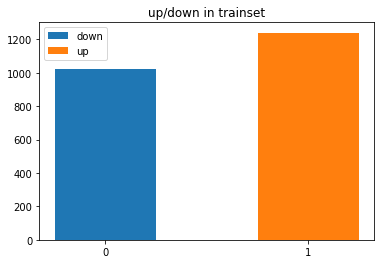

ans_y 0:  119
ans_y 1:  133


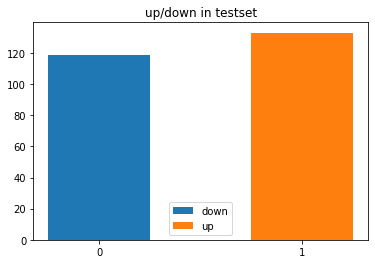

In [10]:
print('ans_x 0: ', list(ans_x).count(0))
print('ans_x 1: ', list(ans_x).count(1))
plt.bar('0', list(ans_x).count(0), width=0.5)
plt.bar('1', list(ans_x).count(1), width=0.5)
plt.title('up/down in trainset')
plt.legend(['down','up'])
plt.show()

print('ans_y 0: ', list(ans_y).count(0))
print('ans_y 1: ', list(ans_y).count(1))
plt.bar('0', list(ans_y).count(0), width=0.5)
plt.bar('1', list(ans_y).count(1), width=0.5)
plt.title('up/down in testset')
plt.legend(['down','up'])
plt.show()

- 定義評分 function，方便我看到模型的結果好壞

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

def performance(ans_y, predictions):
    print('accuracy_score: ', accuracy_score(ans_y, predictions))
    print('recall_score:   ', recall_score(ans_y, predictions))
    print('precision_score:', precision_score(ans_y, predictions))
    print('f1_score:       ', f1_score(ans_y, predictions))
    tn, fp, fn, tp = confusion_matrix(ans_y, predictions).ravel()
    print('tn, fp, fn, tp: ', tn, fp, fn, tp)

## 模型訓練與預測

### LogisticRegression
- train_X 是用前一天 scale 過後的資料
- train_Y 是用今天的 Close Price
- 印出 trainset 上的各種分數

In [12]:
from sklearn.linear_model import LogisticRegression

modelLG = LogisticRegression(random_state=1022, solver="liblinear", multi_class='auto')
modelLG.fit(train_X, df_train['Close Price'][1:].astype('int'))
pred = modelLG.predict(train_X)

clear_output()
predictions = getdiff(pred, True)
performance(ans_x, predictions)

accuracy_score:  0.5395492708793637
recall_score:    0.8781275221953188
precision_score: 0.5497726124305204
f1_score:        0.6761963952765693
tn, fp, fn, tp:  133 891 151 1088


- 畫出 trainset 上 predict 價錢的結果

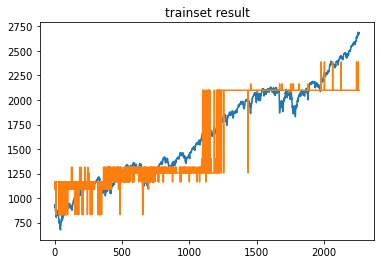

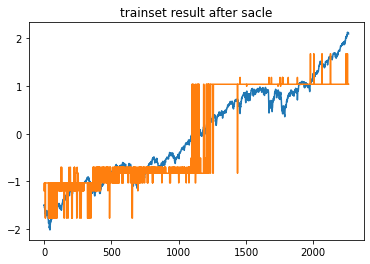

In [13]:
plt.plot(range(len(df_train)-1), df_train['Close Price'][1:].astype('int'))
plt.plot(range(len(df_train)-1), pred)
plt.title('trainset result')
plt.show()

plt.plot(range(len(df_train)-1), preprocessing.scale(df_train['Close Price'][1:].astype('int')))
plt.plot(range(len(df_train)-1), preprocessing.scale(pred))
plt.title('trainset result after sacle')
plt.show()

#### 查看在testset上的成果

In [14]:
pred2 = modelLG.predict(test_X)

clear_output()
predictions2 = getdiff(pred2, True)
performance(ans_y, predictions2)

accuracy_score:  0.5277777777777778
recall_score:    0.8345864661654135
precision_score: 0.5336538461538461
f1_score:        0.6510263929618768
tn, fp, fn, tp:  22 97 22 111


- 畫出 testset 上 predict 價錢的結果

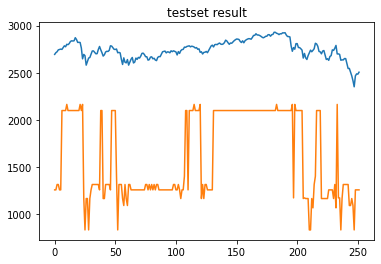

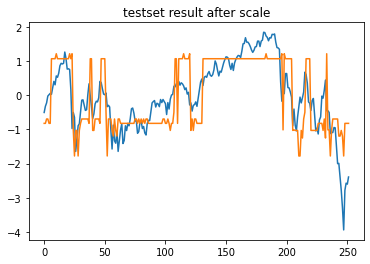

In [15]:
plt.plot(range(len(df_test)), df_test['Close Price'].astype('int'))
plt.plot(range(len(df_test)), pred2)
plt.title('testset result')
plt.show()

plt.plot(range(len(df_test)), preprocessing.scale(df_test['Close Price'].astype('int')))
plt.plot(range(len(df_test)), preprocessing.scale(pred2))
plt.title('testset result after scale')
plt.show()

### RandomForestRegressor
- train_X 是用前一天 scale 過後的資料
- train_Y 是用今天的 Close Price
- 印出 trainset 上的各種分數

In [16]:
from sklearn.ensemble import RandomForestRegressor

modelRFG = RandomForestRegressor(random_state=1022, max_depth=10, min_samples_split=5, oob_score=True)
modelRFG.fit(train_X, df_train['Close Price'][1:].astype('int'))
pred = modelRFG.predict(train_X)

clear_output()
predictions = getdiff(pred, True)
performance(ans_x, predictions)

accuracy_score:  0.7026071586389748
recall_score:    0.7433414043583535
precision_score: 0.7217868338557993
f1_score:        0.7324055666003976
tn, fp, fn, tp:  669 355 318 921


- 畫出 trainset 上 predict 價錢的結果

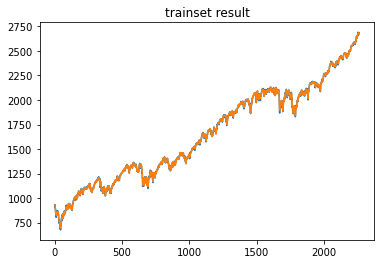

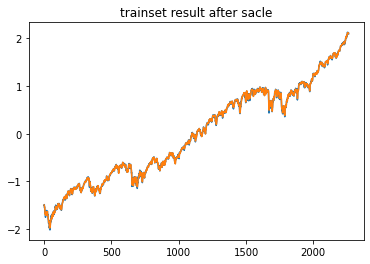

In [17]:
plt.plot(range(len(df_train)-1), df_train['Close Price'][1:].astype('int'))
plt.plot(range(len(df_train)-1), pred)
plt.title('trainset result')
plt.show()

plt.plot(range(len(df_train)-1), preprocessing.scale(df_train['Close Price'][1:].astype('int')))
plt.plot(range(len(df_train)-1), preprocessing.scale(pred))
plt.title('trainset result after sacle')
plt.show()

#### 查看在testset上的成果

In [18]:
pred2 = modelRFG.predict(test_X)

clear_output()
predictions2 = getdiff(pred2, True)
performance(ans_y, predictions2)

accuracy_score:  0.5238095238095238
recall_score:    0.5789473684210527
precision_score: 0.5460992907801419
f1_score:        0.562043795620438
tn, fp, fn, tp:  55 64 56 77


- 畫出 testset 上 predict 價錢的結果

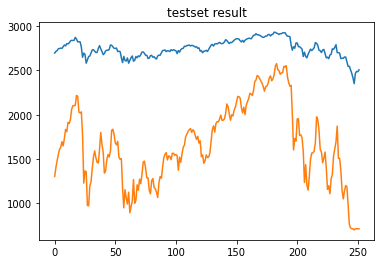

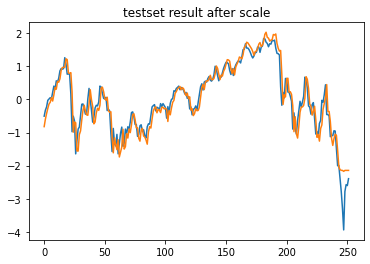

In [19]:
plt.plot(range(len(df_test)), df_test['Close Price'].astype('int'))
plt.plot(range(len(df_test)), pred2)
plt.title('testset result')
plt.show()

plt.plot(range(len(df_test)), preprocessing.scale(df_test['Close Price'].astype('int')))
plt.plot(range(len(df_test)), preprocessing.scale(pred2))
plt.title('testset result after scale')
plt.show()

## 與前面不同的訓練方法
- 這邊是用**前N天的漲跌情況**去 predict **下一天的漲幅**
- 所以這邊一樣要拿到每個漲幅情況

In [20]:
vary = getdiff(df_train['Close Price'])
print(vary.shape)

ans_y = getdiff(df_test['Close Price'], True)
print(ans_y.shape)

(2263,)
(252,)


###  得到訓練資料
- getLen 為控制我要拿前面 `多少天的漲跌情況` 的參數
- 假設 getLen=10, train_X 就會有 10天的 漲跌情況
- train_Y 就是當天的 漲跌情況 (1/0)

In [21]:
tmp = []
getLen = 15
for i in range(len(vary)):
    if getLen == len(vary[i:i+getLen]):
        tmp.append(vary[i:i+getLen])
tmp.pop()
train_X = np.array(tmp)
print('train_X:')
print(train_X.shape)
print(train_X[:5])

print('\ntrain_Y:')
train_Y = vary[getLen:]
print(train_Y.shape)
print(train_Y[:5])

train_X:
(2248, 15)
[[0 1 0 1 0 0 1 0 1 1 0 1 0 1 1]
 [1 0 1 0 0 1 0 1 1 0 1 0 1 1 1]
 [0 1 0 0 1 0 1 1 0 1 0 1 1 1 1]
 [1 0 0 1 0 1 1 0 1 0 1 1 1 1 0]
 [0 0 1 0 1 1 0 1 0 1 1 1 1 0 0]]

train_Y:
(2248,)
[1 1 0 0 0]


### 模型訓練 - LogisticRegression
- 以前述的 train_X 與 train_Y 下去訓練
- 印出 trainset 上的各種分數

In [22]:
from sklearn.linear_model import LogisticRegression

modelLG = LogisticRegression(random_state=1022, solver="saga", multi_class='auto')

modelLG.fit(train_X, train_Y)
pred = modelLG.predict(train_X)

clear_output()
performance(train_Y, pred)

accuracy_score:  0.552491103202847
recall_score:    0.867587327376117
precision_score: 0.5588697017268446
f1_score:        0.6798217695735201
tn, fp, fn, tp:  174 843 163 1068


#### 查看在testset上的成果
- 由於我是拿前面 N天的情況下去當資料，所以我必須一天一天 predict
- 將每天新的 predict 結果更新到 text_X 裡面，並記錄全部的 predict 結果

In [23]:
predictions = []
test_X = vary[-getLen-1:-1].reshape(-1, getLen)

for i in range(len(ans_y)):
    getpred = modelLG.predict(test_X)
    predictions.append(getpred[0])
    test_X[0][:-1] = test_X[0][1:]
    test_X[0][-1] = getpred[0]

performance(ans_y, predictions)

accuracy_score:  0.5595238095238095
recall_score:    0.849624060150376
precision_score: 0.553921568627451
f1_score:        0.6706231454005935
tn, fp, fn, tp:  28 91 20 113


### 模型訓練 - RandomForestClassifier
- 以前述的 train_X 與 train_Y 下去訓練
- 印出 trainset 上的各種分數

In [0]:
vary = getdiff(df_train['Close Price'])

ans_y = getdiff(df_test['Close Price'], True)

tmp = []
getLen = 15
for i in range(len(vary)):
    if getLen == len(vary[i:i+getLen]):
        tmp.append(vary[i:i+getLen])
tmp.pop()

train_X = np.array(tmp)
train_Y = vary[getLen:]

In [25]:
from sklearn.ensemble import RandomForestClassifier

modelRFG = RandomForestClassifier(random_state=1022, n_estimators = 100, max_depth=12, min_samples_split=5, oob_score=True)

modelRFG.fit(train_X, train_Y)
pred = modelRFG.predict(train_X)

clear_output()
performance(train_Y, pred)

accuracy_score:  0.9314946619217082
recall_score:    0.9756295694557271
precision_score: 0.9064150943396226
f1_score:        0.9397496087636933
tn, fp, fn, tp:  893 124 30 1201


#### 查看在testset上的成果
- 由於我是拿前面 N天的情況下去當資料，所以我必須一天一天 predict
- 將每天新的 predict 結果更新到 text_X 裡面，並記錄全部的 predict 結果

In [26]:
predictions = []
test_X = vary[-getLen-1:-1].reshape(-1, getLen)

for i in range(len(ans_y)):
    getpred = modelRFG.predict(test_X)
    predictions.append(getpred[0])
    test_X[0][:-1] = test_X[0][1:]
    test_X[0][-1] = getpred[0]

performance(ans_y, predictions)

accuracy_score:  0.5714285714285714
recall_score:    0.6090225563909775
precision_score: 0.5912408759124088
f1_score:        0.6000000000000001
tn, fp, fn, tp:  63 56 52 81


## Neural Network
- 選用適合用在時間序列上的 LSTM 來做
- 出於好奇也有試 Conv1D，但效果不佳

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Conv1D
from keras.optimizers import adam
from keras.callbacks import EarlyStopping


Using TensorFlow backend.


### 第一種方法
- 用前一天的 `Open Price`, `Close Price`, `High Price`, `Low Price`, `Volume` 當一筆 train_X
- 用當天的 `Close Price` 當 train_Y
- 因為 `Volume` 與價錢差距太大所以會全部做 scale

In [28]:
train_X = preprocessing.scale(df_train[['Open Price','Close Price', 'High Price', 'Low Price', 'Volume']][:-1])

test_X = pd.DataFrame(df_train[['Open Price','Close Price', 'High Price', 'Low Price', 'Volume']][-1:])
test_X = test_X.append(pd.DataFrame(df_test[['Open Price','Close Price', 'High Price', 'Low Price', 'Volume']][:-1]), ignore_index = True)
test_X = preprocessing.scale(test_X)

clear_output()
print('train X')
print(train_X.shape)
print(train_X[:5])

print('\ntest X')
print(test_X.shape)
test_X[:5]

train X
(2263, 5)
[[-1.5525723  -1.49460743 -1.50568322 -1.5411813   0.81317476]
 [-1.4985713  -1.50358103 -1.50176025 -1.49958133  1.82382578]
 [-1.49444594 -1.48862502 -1.48685296 -1.48360512  1.80806999]
 [-1.50211912 -1.54648932 -1.52071439 -1.53495573  1.29914778]
 [-1.54692055 -1.54013559 -1.55674377 -1.54641737  1.51125538]]

test X
(252, 5)


array([[-0.60956457, -0.73810299, -0.77958363, -0.54464921, -1.79825248],
       [-0.66507711, -0.51389255, -0.73839392, -0.4614655 , -0.66999679],
       [-0.52045772, -0.33967497, -0.53648781, -0.3149671 , -0.13420764],
       [-0.30066083, -0.22928668, -0.37347704, -0.11247419, -0.11188255],
       [-0.17754999, -0.03577893, -0.21876977, -0.0283398 , -0.51108983]])

- 用漲疊去當 ans，用以驗證 accuracy

In [29]:
ans_x = getdiff(df_train['Close Price'])
print(ans_x.shape)

ans_y = getdiff(df_test['Close Price'], True)
print(ans_y.shape)

train_Y = df_train['Close Price'][1:].astype('int').values
train_Y.shape

train_X = train_X.reshape(-1, 1, 5)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 5)

(2263,)
(252,)


#### 模型建置
- 調整超參數

In [0]:
epochs = 50
batch_size = 50
lr = 1e-3

- 這邊選用雙向的 LSTM 再加上幾層 fully
- 避免 overfitting 加入了 earlystoping 的機制

In [31]:
import timeit

start = timeit.default_timer()

model = Sequential()
model.add(Bidirectional(LSTM(200, input_shape=(1, 5), activation='relu', return_sequences=True)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer=adam(lr=lr), metrics=['mae', 'mse'])

early_stopping = EarlyStopping(monitor='mse', patience=10, verbose=2)

model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs, callbacks=[early_stopping])

stop = timeit.default_timer()
print('Time: ', stop - start)  

Epoch 1/50
2263/2263 [==============================] - 1s 639us/step - loss: 2957006.0373 - mae: 1649.5541 - mse: 2957005.7500
Epoch 2/50
2263/2263 [==============================] - 0s 209us/step - loss: 1766166.0218 - mae: 1197.5813 - mse: 1766166.2500
Epoch 3/50
2263/2263 [==============================] - 0s 200us/step - loss: 524761.7540 - mae: 622.3994 - mse: 524761.7500
Epoch 4/50
2263/2263 [==============================] - 0s 190us/step - loss: 288301.9593 - mae: 454.3331 - mse: 288301.9688
Epoch 5/50
2263/2263 [==============================] - 0s 195us/step - loss: 112705.5182 - mae: 263.2714 - mse: 112705.5156
Epoch 6/50
2263/2263 [==============================] - 0s 192us/step - loss: 55206.2508 - mae: 178.4154 - mse: 55206.2539
Epoch 7/50
2263/2263 [==============================] - 0s 186us/step - loss: 35462.8822 - mae: 142.5081 - mse: 35462.8867
Epoch 8/50
2263/2263 [==============================] - 0s 182us/step - loss: 23248.6659 - mae: 117.5129 - mse: 23248.6641


#### 查看 trainset 上的成果

In [32]:
pred = model.predict(train_X)
pred = pred.squeeze()

predictions = getdiff(pred, True)
performance(ans_x, predictions)

accuracy_score:  0.4891736632788334
recall_score:    0.5472154963680388
precision_score: 0.5326001571091908
f1_score:        0.5398089171974523
tn, fp, fn, tp:  429 595 561 678


#### 查看 testset 上的成果

In [33]:
pred2 = model.predict(test_X)
pred2 = pred2.squeeze()

predictions2 = getdiff(pred2, True)
performance(ans_y, predictions2)

accuracy_score:  0.5238095238095238
recall_score:    0.5488721804511278
precision_score: 0.5488721804511278
f1_score:        0.5488721804511278
tn, fp, fn, tp:  59 60 60 73


#### 畫出成果圖
- 比較一下 model 預測的股價與實際股價

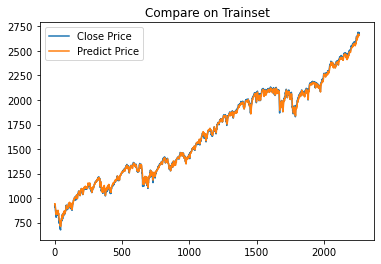

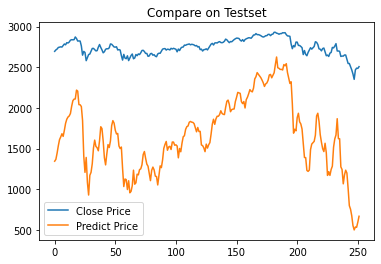

In [34]:
plt.plot(range(len(pred)), train_Y.squeeze())
plt.plot(range(len(pred)), pred)
plt.legend(['Close Price','Predict Price'])
plt.title('Compare on Trainset')
plt.show()
plt.plot(range(len(pred2)), df_test['Close Price'])
plt.plot(range(len(pred2)), pred2)
plt.legend(['Close Price','Predict Price'])
plt.title('Compare on Testset')
plt.show()

- 試著畫了下 scale 後的結果，發現是會比較貼合的

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


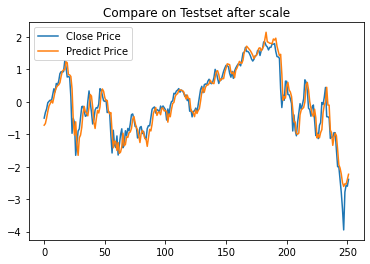

In [35]:
plt.plot(range(len(pred2)), preprocessing.scale(df_test['Close Price']))
plt.plot(range(len(pred2)), preprocessing.scale(pred2))
plt.legend(['Close Price','Predict Price'])
plt.title('Compare on Testset after scale')
plt.show()

### 第二種方法
- 用前 N 天的 `Close Price`, `Volume` 當一筆 train_X
- 用當天的 `Close Price` 當 train_Y
- 一樣會對 train_X 的資料先做 scale

In [36]:
df_train['Scale Close'] = preprocessing.scale(df_train['Close Price'])
df_train['Scale Volume'] = preprocessing.scale(df_train['Volume'])
df_test['Scale Close'] = preprocessing.scale(df_test['Close Price'])
df_test['Scale Volume'] = preprocessing.scale(df_test['Volume'])
clear_output()

getLen = 15

tmp = []
for i in range(len(df_train['Close Price'])):
    if getLen == len(df_train[['Close Price', 'Volume']][i:i+getLen]):
        tmp.append(np.array(df_train[['Scale Close', 'Scale Volume']][i:i+getLen]).reshape(2*getLen))
tmp.pop()

train_X = np.array(tmp)
train_Y = np.array(df_train['Close Price'][getLen:])
print(train_X.shape)
print(train_X[:2])
print(train_Y[:2])

# get test data
tmp = []
for i in range(getLen, 0, -1):
    tmp.append(np.concatenate((np.array(df_train[['Scale Close', 'Scale Volume']][-i:]).reshape(2*i), np.array(df_test[['Scale Close', 'Scale Volume']][0:getLen-i]).reshape(2*(getLen-i))), axis=None))
for i in range(len(df_test['Close Price'])):
    if getLen == len(df_test[['Close Price', 'Volume']][i:i+getLen]):
        tmp.append(np.array(df_test[['Scale Close', 'Scale Volume']][i:i+getLen]).reshape(2*getLen))
tmp.pop()

test_X = np.array(tmp)
test_Y = np.array(df_test['Close Price'])
print(test_X.shape)

(2249, 30)
[[-1.49441197  0.81362581 -1.50337884  1.82418053 -1.48843406  1.80842623
  -1.54625493  1.29955252 -1.53990597  1.51163991 -1.57985493  1.30810671
  -1.62126746  1.31443351 -1.61811359  1.53082035 -1.67824318  1.81971854
  -1.67593446  3.5952933  -1.66278305  2.83953764 -1.75533767  2.53554402
  -1.68314919  2.6040666  -1.70941079  2.14231521 -1.70023778  2.13367993]
 [-1.50337884  1.82418053 -1.48843406  1.80842623 -1.54625493  1.29955252
  -1.53990597  1.51163991 -1.57985493  1.30810671 -1.62126746  1.31443351
  -1.61811359  1.53082035 -1.67824318  1.81971854 -1.67593446  3.5952933
  -1.66278305  2.83953764 -1.75533767  2.53554402 -1.68314919  2.6040666
  -1.70941079  2.14231521 -1.70023778  2.13367993 -1.69071434  2.28743415]]
[836.57 845.71]
(252, 30)


- 用漲疊去當 ans，用以驗證 accuracy

In [37]:
ans_x = getdiff(df_train['Close Price'][getLen:])
print(ans_x.shape)

ans_y = getdiff(df_test['Close Price'], True)
print(ans_y.shape)

train_X = train_X.reshape(-1, 1, 2*getLen)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2*getLen)

(2248,)
(252,)


#### 模型建置
- 調整超參數

In [0]:
epochs = 30
batch_size = 50
lr = 8e-4

- 這邊選用 LSTM 再加上幾層 fully
- 避免 overfitting 加入了 earlystoping 的機制

In [39]:
import timeit

start = timeit.default_timer()

model = Sequential()
model.add(LSTM(128, input_shape=(1, 2*getLen), activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer=adam(lr=lr), metrics=['mae', 'mse'])


early_stopping = EarlyStopping(monitor='mse', patience=5, verbose=2)

model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs, callbacks=[early_stopping])

stop = timeit.default_timer()
print('Time: ', stop - start)  

Epoch 1/30
2249/2249 [==============================] - 1s 303us/step - loss: 2992207.1183 - mae: 1661.0155 - mse: 2992207.7500
Epoch 2/30
2249/2249 [==============================] - 0s 129us/step - loss: 2836856.8333 - mae: 1602.2711 - mse: 2836857.5000
Epoch 3/30
2249/2249 [==============================] - 0s 132us/step - loss: 1532642.5697 - mae: 1114.8354 - mse: 1532642.5000
Epoch 4/30
2249/2249 [==============================] - 0s 135us/step - loss: 548644.1375 - mae: 615.2966 - mse: 548644.0000
Epoch 5/30
2249/2249 [==============================] - 0s 130us/step - loss: 410500.8722 - mae: 522.2134 - mse: 410500.8750
Epoch 6/30
2249/2249 [==============================] - 0s 126us/step - loss: 292972.2046 - mae: 432.9518 - mse: 292972.2188
Epoch 7/30
2249/2249 [==============================] - 0s 132us/step - loss: 228009.3684 - mae: 370.4031 - mse: 228009.3438
Epoch 8/30
2249/2249 [==============================] - 0s 140us/step - loss: 204563.6741 - mae: 347.9814 - mse: 204

#### 查看 trainset 上的成果

In [40]:
pred = model.predict(train_X)
pred = pred.squeeze()

predictions = getdiff(pred)
performance(ans_x, predictions)

accuracy_score:  0.4875444839857651
recall_score:    0.49553208773354995
precision_score: 0.5346187554776511
f1_score:        0.5143338954468801
tn, fp, fn, tp:  486 531 621 610


#### 查看 testset 上的成果

In [41]:
pred2 = model.predict(test_X)
pred2 = pred2.squeeze()

predictions2 = getdiff(pred2, True)
performance(ans_y, predictions2)

accuracy_score:  0.5634920634920635
recall_score:    0.6390977443609023
precision_score: 0.5782312925170068
f1_score:        0.6071428571428572
tn, fp, fn, tp:  57 62 48 85


#### 畫出成果圖
- 比較一下 model 預測的股價與實際股價

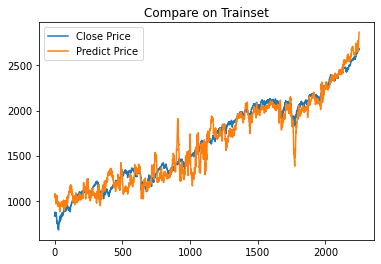

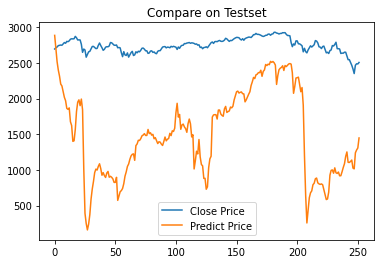

In [42]:
plt.plot(range(len(pred)), train_Y.squeeze())
plt.plot(range(len(pred)), pred)
plt.legend(['Close Price','Predict Price'])
plt.title('Compare on Trainset')
plt.show()
plt.plot(range(len(pred2)), df_test['Close Price'])
plt.plot(range(len(pred2)), pred2)
plt.legend(['Close Price','Predict Price'])
plt.title('Compare on Testset')
plt.show()

- 因為 predict 跟實際價格差距太大，所以這邊畫了 scale 過後的比較圖

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


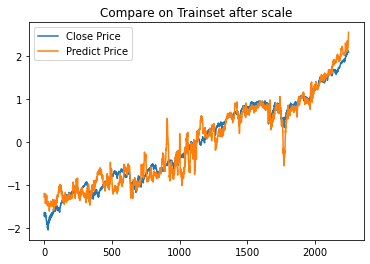

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


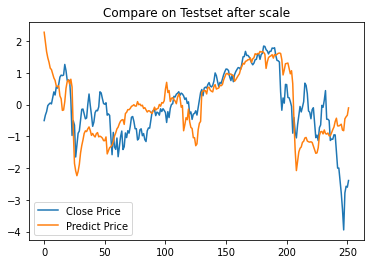

In [43]:
plt.plot(range(len(pred)), preprocessing.scale(train_Y.squeeze()))
plt.plot(range(len(pred)), preprocessing.scale(pred))
plt.legend(['Close Price','Predict Price'])
plt.title('Compare on Trainset after scale')
plt.show()

plt.plot(range(len(pred2)), preprocessing.scale(df_test['Close Price']))
plt.plot(range(len(pred2)), preprocessing.scale(pred2))
plt.legend(['Close Price','Predict Price'])
plt.title('Compare on Testset after scale')
plt.show()

# Discussion



## How did you preprocess this dataset ?
- 根據不同的方法我做了不同的處理
    - 如果用到 Volume 時我就會把所有的 data 做 scale，讓彼此之間的差距不會太大
    - 需要用到前 N 天的資料時，我就會把 N 天的資料放在一起，並且做 reshape 符合 model 的 input
    - 其中一種方式我的資料是直接放漲跌的情形下去 train， 所以我要先將每一天的 Close Price 做 diff 才能拿到漲疊情況

## Which classifier reaches the highest classification accuracy in this dataset ?
- 直接用漲疊下去 train 的 RandomForestClassifier 是最高的
- trainset: 0.9315
- testset:  0.5714

### Why ?
1. 我認為直接拿漲疊情況(1或0)下去 train 的好處在於他不會受到漲幅或跌幅的影響，重點應該就會放在連續的漲或跌
2. 我認為 RandomForestClassifier 是經過 ensemble 的方法，在分類問題下會比 logistic regression 好是可以理解的

### Can this result remain if the dataset is different ?
- RandomForestClassifier 看出明顯的 overfitting，但他的 test accuracy 還是最高的 0.57。
- 再拿 logistic regression 的來看，會發現在 train 跟 test 上都是 0.55 左右，看似效果還不錯。
- 但回到 confusion matrix 上就會發現 logistic regression 的 false/true positive 都滿高的，可見 model 猜了一堆 1，而在 RandomForest 的猜測分布還算平均。

## How did you improve your classifiers ?
- 嘗試 3 種不同的方式去處理 data
    - 拿前一天的資料
    - 拿前 N 天的資料
    - 拿前 N 天的漲跌情況
- 調整參數
    - LogisticRegression
        - solver: 在預測股價時選用 `liblinear`, 在二分類時選用 `saga`
    - RandomForest
        - n_estimators: 產生更多種可能
        - max_depth: 降低 overfitting
        - min_samples_split: 避免將資料劃分太小
        - oob_score: 設成 True 讓他可以自行驗證

- Neural Network
    - 選用 LSTM，也用了雙向的 LSTM 但效果差不多
    - 選用 Conv1D 但效果欠佳
    - 調整 learning rate 改變 gradient descent 效果
    - Loss 選用適合用在數值的 mse
    - activation 用較不容易 vanishing gradient 的 relu
    - 使用 early stopping 降低 overfitting
    - 調整 epoch，後面發現 epoch 小一點的效果會比較好，我認為是跟 overfitting 有關係
- 總結
    - NN 的效果比我用 randomforest 還差，我想是我不太會疊 model
    - 在 testset 上的作圖，我發現 scale 過後其實滿相似的，但 accuracy 還是很差
    - 有些時候 confusion matrix 分布不平均但 accuracy 變高，因為 model 幾乎都猜 1